# Overview
1. What is Nipype?
2. Interfaces
3. Workflows

## 1. What is Nipype?
Nipype allows you to:
* easily interact with tools from different software packages (FSL, AFNI, ANTs, etc.)
* combine processing steps from different software packages
* develop new workflows faster by reusing common steps from old ones
* process data faster by running it in parallel on many cores/machines
* **make your research easily reproducible**
* share your processing workflows with the community

(source: from nipype.readthedocs.io)

## 2. Interfaces
Nipype interfaces let you interact with neuroimaging tools from different software packages in Python.

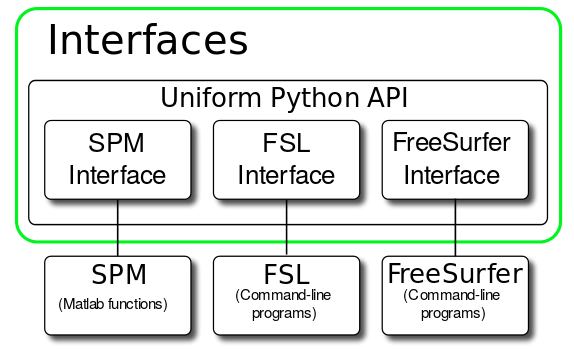
 (source: from nipype.readthedocs.io)

Run this setup code before running the notebook:

In [ ]:
import os
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"

### 2.1 Skullstrip using FSL's BET

BET is a skullstripping tool in FSL.
Let's import its Nipype interface and use it to skullstrip an image.

In [ ]:
from nipype.interfaces.fsl import BET

Let's use the BET interface to skullstrip an image.

First, we need to define the image file we want to use.

In [ ]:
t1w_image_file = "./data/T1w_acpc_dc_restore_1mm.nii.gz"

Let's import nilearn plotting to view the input image.

In [ ]:
from nilearn.plotting import plot_anat
plot_anat(t1w_image_file)

Second, we need to define where we want the output file to be saved.

In [ ]:
fsl_output_file = "./outputs/fsl_skullstripped.nii.gz"

Third, we'll define the interface.

In [ ]:
bet_interface = BET(in_file=t1w_image_file, # Here we are telling BET which input file to use
                    out_file=fsl_output_file) # Here we are telling BET where to save the output file

Finally, we'll run the interface.

In [ ]:
result = bet_interface.run()

#### --> Challenge: plot the output image

<details>
<summary>Click here for hint #1</summary>
use nilearn's plot_anat function
</details>

<details>
<summary>Click here for hint #2</summary>
the fsl_output_file variable contains the output file location
</details>

<details>
<summary>Click here for answer</summary>

```plot_anat(fsl_output_file)```

</details>

#### --> Advanced Challenge: display only axial slices

<details>
<summary>Click here for hints</summary>
Hint #1: type "help(plot_anat)" to read the function documents

Hint #2: look at the "display_mode" argument

Hint #3: set "display_mode='z'"
</details>

<details>
<summary>Click here for answer</summary>

```plot_anat(fsl_output_file, display_mode="z")```

</details>

### 2.2 Smoothing the image using FSL

Now that we have done the skullstripping for the T1w image, let's smooth the skullstripped image using FSL.

In [ ]:
from nipype.interfaces.fsl import Smooth

Set the output filename

In [ ]:
smoothed_output_file = "./outputs/smoothed.nii.gz"

Define the smoothing interface

In [ ]:
smooth_interface = Smooth(in_file=fsl_output_file, # Here we are telling FSL which input file to use
                          smoothed_file=smoothed_output_file, # Here we are telling FSL where to save the output file
                          sigma=4)  # The size of the kernel for smoothing the image 

#### --> Challenge: run the interface and plot the result

<details>
<summary>Click here for answer</summary>

```
smooth_interface.run()<br>
plot_anat(smoothed_output_file)
```

</details>

What if we wanted to combine the skullstripping and smoothing into a single operation? That's where workflows can help us!

## 3. Workflows

Nipype workflows let you combine processing steps from different software packages.

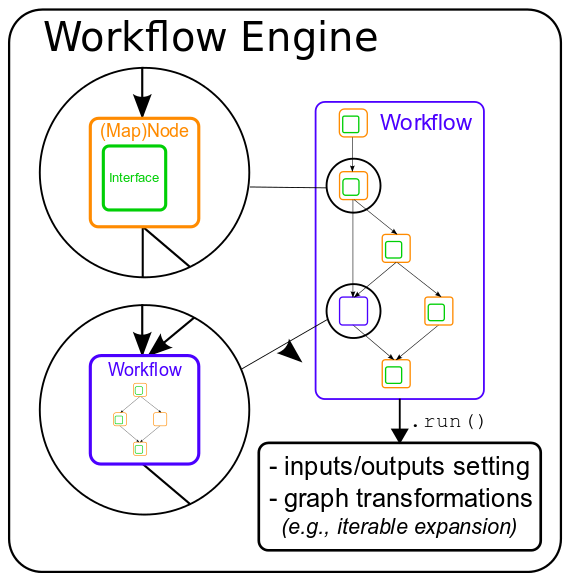
 (source: from nipype.readthedocs.io)

In the example earlier, we ran the skullstripping with BET and then smoothed the image. We are now going to create  a workflow that will do both! It will first skullstrip the image and then pass the skullstripped image to the smoothing interface.

To make the workflow we will need to use 2 more tools from Nipype: nodes and workflows.

In [ ]:
from nipype import Node, Workflow

The ***workflow*** is a set of processing steps pieced together in a given order. A ***node*** is a step in the workflow that contains the interface that we want to run at that step.

For the skullstripping step, first we define the interface like before:

In [ ]:
bet_interface = BET(in_file=os.path.abspath(t1w_image_file))

Next we need to define the node that will contain the interface:

In [ ]:
bet_node = Node(bet_interface,
                name="SkullStrip")

The above create a node that contains the BET interface and givess it the name "SkullStrip".

Now we need to create the smoothing node:

In [ ]:
smooth_interface = Smooth(sigma=4)  # The smoothing interface
smooth_node = Node(smooth_interface, name="Smooth")  # The smoothing node

Now that we have our two nodes, we need to create our workflow.

In [ ]:
my_workflow = Workflow(name="MyWorkflow",
                       base_dir="./")

The code above defines the name of the workflow as "MyWorkflow" and tells it to run in the current directory.

The key to the workflow is to connect the two nodes:

In [ ]:
my_workflow.connect(bet_node, "out_file", smooth_node, "in_file")

This connects the BET node to the smoothing node so that the output of BET will be passed to the smoothing node.

We can view the graph of the workflow.

In [ ]:
from IPython.display import Image

Image(my_workflow.write_graph("./figures/my_workflow.dot"))

The image shows the names of our two nodes. It shows the Skullstrip node output being passed to the Smooth node. It also shows the name of the workflow as "MyWorkflow".

Now, run the workflow.

In [ ]:
result = my_workflow.run()

In [ ]:
output_file = "./MyWorkflow/Smooth/T1w_acpc_dc_restore_1mm_brain_smooth.nii.gz"

In [ ]:
plot_anat(output_file)

#### --> Challenge: reduce the level of smoothing (sigma), run the workflow, and replot the result

Hint: Remember to re-run the code that defines the nodes and workflow.

#### --> Advanced challenge (part 1): recreate the same workflow, but run the smoothing before running the skullstripping.

In [ ]:
adv_workflow = Workflow("AdvancedChallengeWF", base_dir="./") 
# finish the workflow...

<details>
<summary>Click here for hints</summary>
Hint #1: The Smooth interface should take the T1w input image.

Hint #2: ```smooth_node = Node(Smooth(in_file=os.path.abspath(t1w_image_file), sigma=4), name="Smooth")```

Hint #3: The BET interface can specify the output name for convience. 

Hint #4: ```bet_node = Node(BET(out_file="stripped.nii.gz"), name="SkullStrip")```

Hint #5: The output from the smooth node will be smoothed_file .

Hint #6: ```adv_workflow.connect(smooth_node, "smoothed_file", bet_node, "in_file")```

Hint #7: The ouptut file from the skullstripping will be ```./AdvancedChallengeWF/SkullStrip/stripped.nii.gz```

</details>

<details>
<summary>Click here for answer</summary>
    
```
smooth_node = Node(Smooth(in_file=os.path.abspath(t1w_image_file), sigma=4), name="Smooth")
bet_node = Node(BET(out_file="stripped.nii.gz"), name="SkullStrip")
adv_workflow.connect(smooth_node, "smoothed_file", bet_node, "in_file")
adv_workflow.run()
plot_anat("./AdvancedChallengeWF/SkullStrip/stripped.nii.gz")
```
    
</details>

#### --> Advanced challenge (part 2):  show the workflow graph for the new workflow

<details>
<summary>Click here for answer</summary>
    
```Image(adv_workflow.write_graph("./figures/adv_workflow.dot"))```

</details>

### Links to learn more about how to use nipype:
* https://miykael.github.io/nipype_tutorial/
* https://peerherholz.github.io/workshop_weizmann/index.html